In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from datetime import date
from lightgbm import LGBMClassifier

os.chdir("../")
base_path = os.getcwd()

from machine_learning.mlMethods import *
from machine_learning.mlSupportMethods import *
from machine_learning.visualization import *

The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


## 1. Importando base de dados

In [3]:
'''
Escolha o tipo de variável dependente, se por valor absoluto ou por taxa de 100 habitantes 
'''

# target = 'dengue_diagnosis'
target = "taxa_dengue"

if target == "taxa_dengue":
    df_dengue_origem = pd.read_csv(base_path + "/data_sus/finais/dengue_input_from_source_taxa.csv")
else:
    df_dengue_origem = pd.read_csv(base_path + "/data_sus/finais/dengue_input_from_source_v2.csv")


# Selecione quais as variáveis serão utilizadas para o treinamento do modelo

columns_filtered = ['Populacao', 'mes',
                    't-1', 't-2', 't-3', 't-4', 't-5', 't-6',
                    # 't-7', 't-8', 't-9', 't-10', 't-11', 't-12',
                    'temperatura (°C)-1', 'precipitacao (mm)-1',
                    'umidade ar (%)-2', 'sum_vizinhos_t-1']

categorical_columns = ['mes']

columns_filtered_categorical = ['mes_3']

neighbor_columns = ['sum_vizinhos_t-1']

## 2. Separando em bases de treino e teste

In [4]:
'''
Metodo separa base de treino e teste de acordo com o ano enviado no parametro
'''

def read_and_prepare(df_input, ano_teste, mes_teste, ano_treino):

    df_treino = df_input[df_input['ano'].isin(
        list(range(ano_teste - ano_treino, ano_teste, 1)))]
    df_teste = df_input[df_input['ano'].isin(
        list(range(ano_teste, ano_teste +1, 1)))]
    df_teste = df_teste[df_input['mes'].isin(
        list(range(1, mes_teste+1, 1)))]

    return df_treino, df_teste


df_treino, df_teste = read_and_prepare(df_dengue_origem, ano_teste=2019, mes_teste=12, ano_treino=3)

Boolean Series key will be reindexed to match DataFrame index.


## 3. Preparando a base de treino para entrada no modelo 

In [5]:
'''
Prepara a base de treino, filtrando as colunas que devem ser utilizadas no modelo, 
ele foi criado para pode filtrar também de forma específica as variáveis depois 
da binarização das categoricas
'''

def prepare_base_treino(df_treino, columns_filtered, columns_filtered_categorical,
                            categorical_columns, target_variable='dengue_diagnosis'):

    X_train = df_treino[columns_filtered]
    y_train = df_treino[target_variable]

    X_train = pd.get_dummies(X_train, columns=categorical_columns)

    # Para o caso de haver variáveis categoricas que serão selecionadas
    if not columns_filtered_categorical == []:

        # Tratativa especial para o caso de mês
        if 'mes' in categorical_columns:

            # Irá buscar somente os meses que estão na base de treino, pode ir de 1 a 12
            mes_list = ["mes_{}".format(i) for i in list(df_treino["mes"].unique())]
            mes_list = [m for m in mes_list if m in columns_filtered_categorical]
            categorical_list = [a for a in categorical_columns if not re.match(".*mes.*", a)]

            # Se na lista de variáveis categoricas não tivessem somente o mês
            if len(categorical_list) > 0:
                columns_filtered_categorical_new = categorical_list + mes_list
            else:
                columns_filtered_categorical_new = mes_list

        new_columns_features = [a for a in columns_filtered if a not in categorical_columns]
        X_train = X_train[new_columns_features + columns_filtered_categorical_new]

        meses_ausentes = [m for m in columns_filtered_categorical if re.match(".*mes.*", m) and not m in mes_list]
        if len(meses_ausentes) > 0:
            for m in meses_ausentes:
                X_train[m] = [0] * X_train.shape[0]


    columns, index_time_cols = get_indices_columns_time(X_train.columns)
    X_train = X_train[columns]

    return X_train, y_train


X_train, y_train = prepare_base_treino(df_dengue_origem, columns_filtered, columns_filtered_categorical,
                            categorical_columns, target_variable=target)

## 4. Treinando o modelo e aplicando a previsão


In [6]:
def run_lightGBM_classifier(X_train, y_train, p=1, is_unbalance=False):

    if is_unbalance:
        classifier = LGBMClassifier(n_estimators=100,
                                    boosting='dart',
                                    bagging_freq=1,
                                    feature_fraction=0.7,
                                    random_state=0,
                                    is_unbalance=is_unbalance)
    else:
        classifier = LGBMClassifier(n_estimators=100,
                                    boosting='dart',
                                    bagging_freq=1,
                                    feature_fraction=0.7,
                                    random_state=0,
                                    scale_pos_weight=p)

    auc = apply_cross_validate_classification(X_train, y_train, classifier, 'lightGBM')

    classifier.fit(X_train, y_train)

    return auc, classifier

In [7]:
def apply_cross_validate_classification(X_train, y_train, classifier, model_name):

    scoring = {'precision': 'precision',
               'recall': 'recall',
               'f1': 'f1',
               'accuracy': 'accuracy',
               'roc_auc': 'roc_auc'}

    accuracies = cross_validate(estimator=classifier,
                                X=X_train,
                                y=y_train,
                                scoring=scoring,
                                cv=10)

    print('######################### {} ###########################'.format(model_name))
    print('Acurácia: ({}, {})'.format(round(accuracies['test_accuracy'].mean(), 2),
                                      round(accuracies['test_accuracy'].std(), 2)))
    print('Precisão: ({}, {})'.format(round(accuracies['test_precision'].mean(), 2),
                                      round(accuracies['test_precision'].std(), 2)))
    print('Cobertura: ({}, {})'.format(round(accuracies['test_recall'].mean(), 2),
                                       round(accuracies['test_recall'].std(), 2)))
    print('Métrica-F1: ({}, {})'.format(round(accuracies['test_f1'].mean(), 2),
                                        round(accuracies['test_f1'].std(), 2)))
    print('ROC AUC: ({}, {})'.format(round(accuracies['test_roc_auc'].mean(), 2),
                                        round(accuracies['test_roc_auc'].std(), 2)))

    return round(accuracies['test_roc_auc'].mean(), 2)


In [8]:
def teste_classificacao_analise_por_valor_taxa(percentil):
    '''
    Este método faz a classificação por taxa de dengue ((# casos / população) * 100)
    Importante saber que os valores de t-n e sum_vizinhos precisam ser alterados para terem o valor de taxas
    :return:
    '''

    target = "taxa_dengue"
    # target = 'dengue_diagnosis'
    ano = list(range(2015, 2021))

    if target == "taxa_dengue":
        df_dengue_origem = pd.read_csv(base_path + "/data_sus/finais/dengue_input_from_source_taxa.csv")
    else:
        df_dengue_origem = pd.read_csv(base_path + "/data_sus/finais/dengue_input_from_source.csv")

    columns_filtered = ['Populacao',
                        't-1', 't-2', 't-3', 't-4', 't-5', 't-6',
                        't-7', 't-8', 't-9', 't-10', 't-11', 't-12',
                        'temperatura (°C)-1', 'precipitacao (mm)-1',
                        'umidade ar (%)-2', 'sum_vizinhos_t-1']

    categorical_columns = []

    columns_filtered_categorical = []

    threshold = np.percentile(list(df_dengue_origem[target]), percentil)
    df_dengue_origem["outbreak"] = df_dengue_origem[target].apply(
        lambda x: 1 if x > threshold else 0)

    df_result = pd.DataFrame(columns=['Bairro', 'ano', 'mes', "meses futuro", "outbreak_real",
                                      "outbreak_previsto"])

    for a in ano:

        df_treino, df_teste = read_and_prepare(df_dengue_origem, ano_teste=a, mes_teste=12, ano_treino=3)

        X_train, y_train = prepare_base_treino(df_treino, columns_filtered, columns_filtered_categorical,
                                               categorical_columns, target_variable="outbreak")

        # Isso aqui está certo, estou utilizando o método de preparo da base treino na base teste
        X_teste, y_teste = prepare_base_treino(df_teste, columns_filtered, columns_filtered_categorical,
                                               categorical_columns, target_variable="outbreak")

        for p in list(range(0, 7)):

            if not p == 0:
                X_train.drop(columns=["t-{}".format(p)], inplace=True)
                X_teste.drop(columns=["t-{}".format(p)], inplace=True)

            print(X_teste.columns)

            auc, classifier = run_lightGBM_classifier(X_train, y_train, p=8)

            y_pred = classifier.predict(X_teste)
            y_pred = [round(y, 2) for y in y_pred]

            df_aux = pd.DataFrame(columns=['Bairro', 'ano', 'mes', "meses futuro", "outbreak_real", "outbreak_previsto"])

            df_aux['Bairro'] = df_teste['nome_bairro']
            df_aux['ano'] = df_teste['ano']
            df_aux['mes'] = df_teste['mes']
            df_aux['meses futuro'] = [p] * df_teste.shape[0]
            df_aux["outbreak_real"] = df_teste["outbreak"]
            df_aux["outbreak_previsto"] = list(y_pred)

            df_result = df_result.append(df_aux)

    df_result["outbreak_real"] = df_result["outbreak_real"].apply(lambda x: float(x))
    df_result["outbreak_previsto"] = df_result["outbreak_previsto"].apply(lambda x: float(x))
            
    return df_result

df_result = teste_classificacao_analise_por_valor_taxa(75)

Boolean Series key will be reindexed to match DataFrame index.


Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-1', 't-2', 't-3', 't-4',
       't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Cur

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-3', 't-4', 't-5', 't-6',
       't-7', 't-8', 't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: fe

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-5', 't-6', 't-7', 't-8',
       't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-7', 't-8', 't-9', 't-10',
       't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM

Boolean Series key will be reindexed to match DataFrame index.


Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-1', 't-2', 't-3', 't-4',
       't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Cur

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-3', 't-4', 't-5', 't-6',
       't-7', 't-8', 't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: fe

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-5', 't-6', 't-7', 't-8',
       't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-7', 't-8', 't-9', 't-10',
       't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM

Boolean Series key will be reindexed to match DataFrame index.


Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-1', 't-2', 't-3', 't-4',
       't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Cur

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-3', 't-4', 't-5', 't-6',
       't-7', 't-8', 't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: fe

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-5', 't-6', 't-7', 't-8',
       't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-7', 't-8', 't-9', 't-10',
       't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM

Boolean Series key will be reindexed to match DataFrame index.


Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-1', 't-2', 't-3', 't-4',
       't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Cur

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-3', 't-4', 't-5', 't-6',
       't-7', 't-8', 't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: fe

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-5', 't-6', 't-7', 't-8',
       't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-7', 't-8', 't-9', 't-10',
       't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM

Boolean Series key will be reindexed to match DataFrame index.


Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-1', 't-2', 't-3', 't-4',
       't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Cur

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-3', 't-4', 't-5', 't-6',
       't-7', 't-8', 't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: fe

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-5', 't-6', 't-7', 't-8',
       't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-7', 't-8', 't-9', 't-10',
       't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM

Boolean Series key will be reindexed to match DataFrame index.


Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-1', 't-2', 't-3', 't-4',
       't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Cur

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-3', 't-4', 't-5', 't-6',
       't-7', 't-8', 't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: fe

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-5', 't-6', 't-7', 't-8',
       't-9', 't-10', 't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction

Index(['Populacao', 'temperatura (°C)-1', 'precipitacao (mm)-1',
       'umidade ar (%)-2', 'sum_vizinhos_t-1', 't-7', 't-8', 't-9', 't-10',
       't-11', 't-12'],
      dtype='object')
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM

## 5. Visualização dos resultados

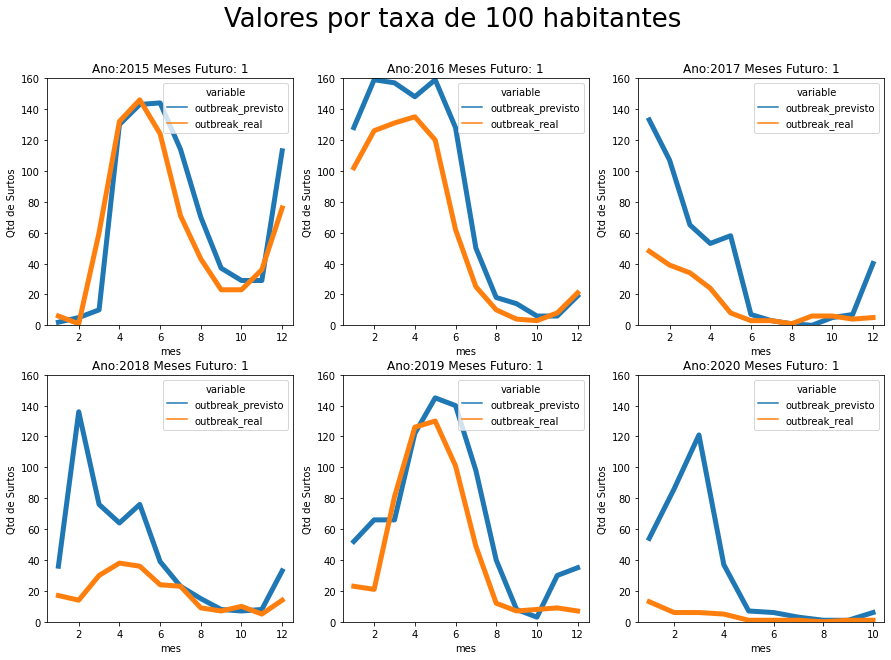

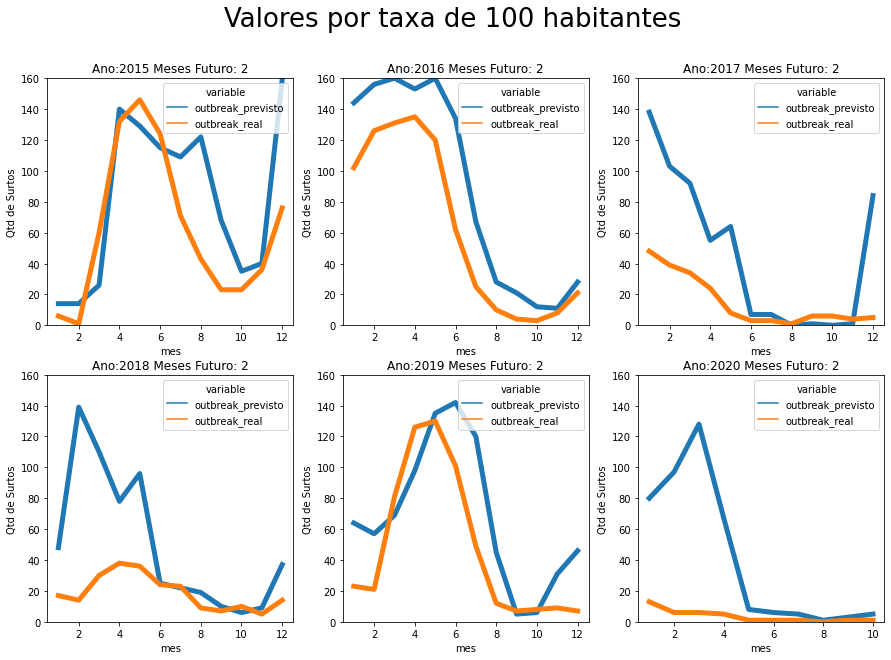

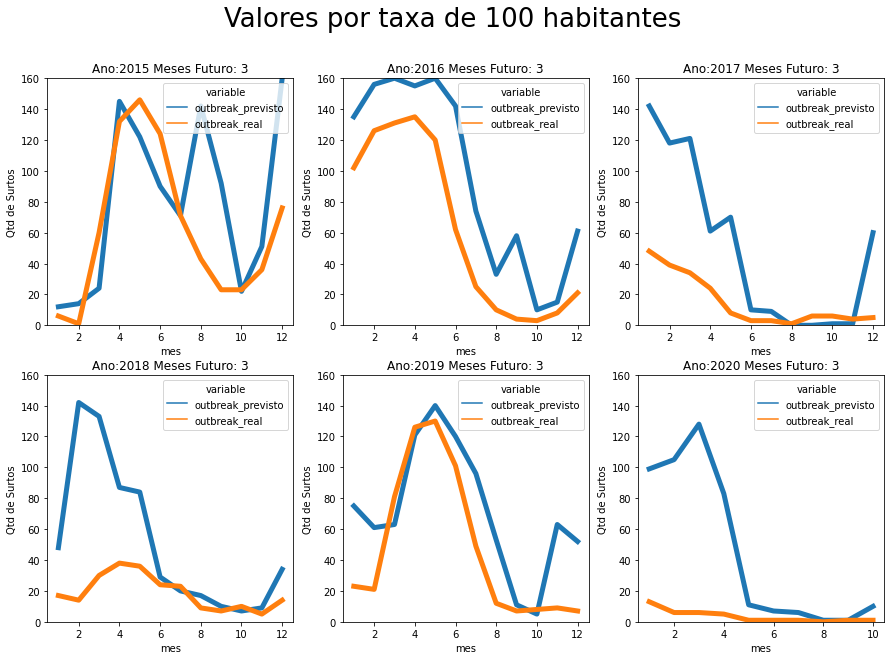

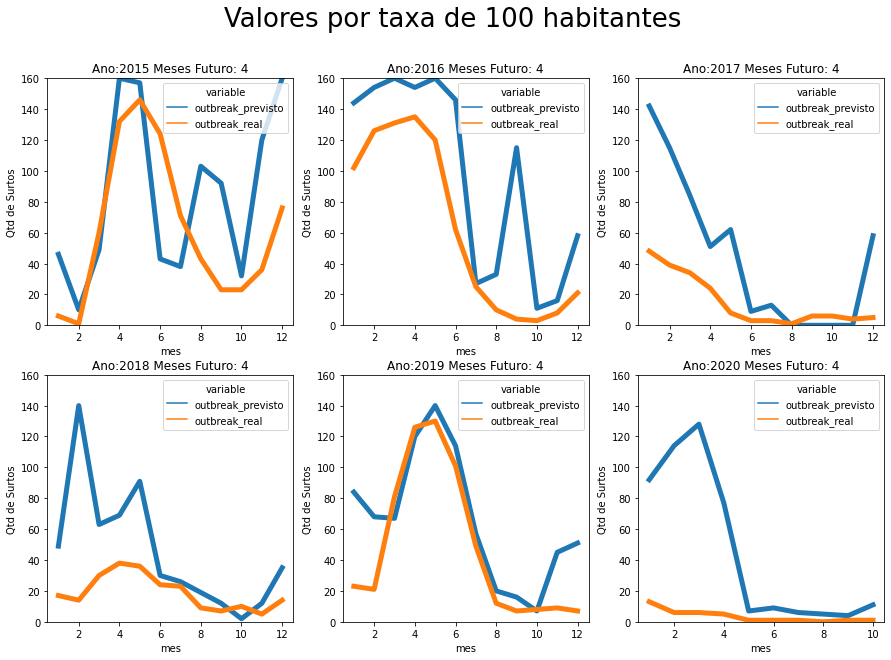

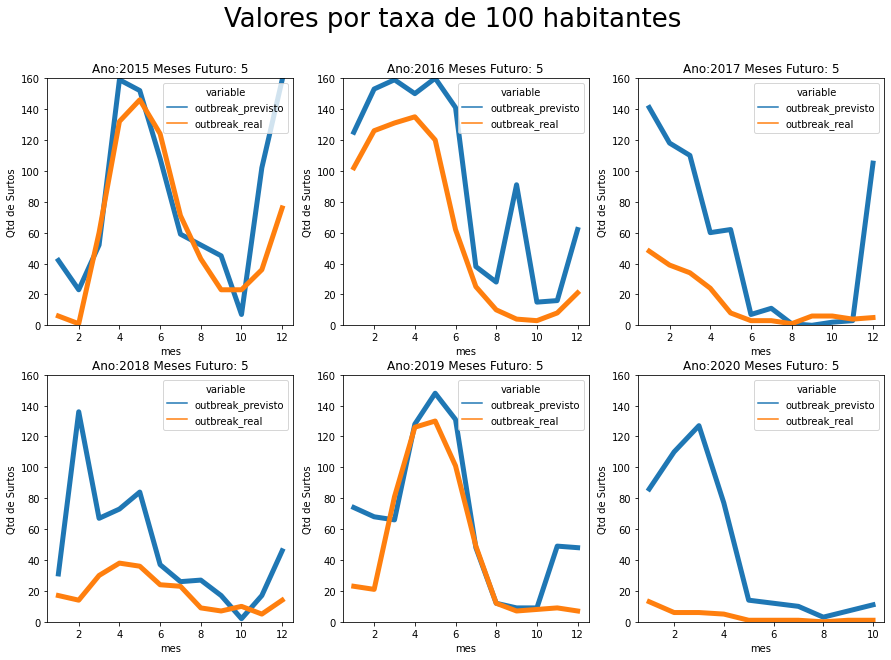

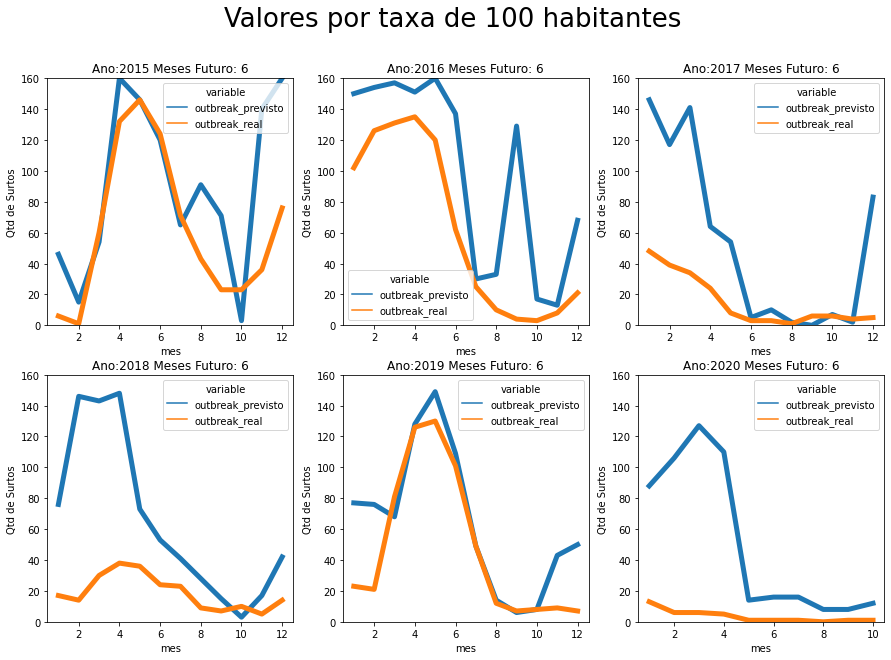

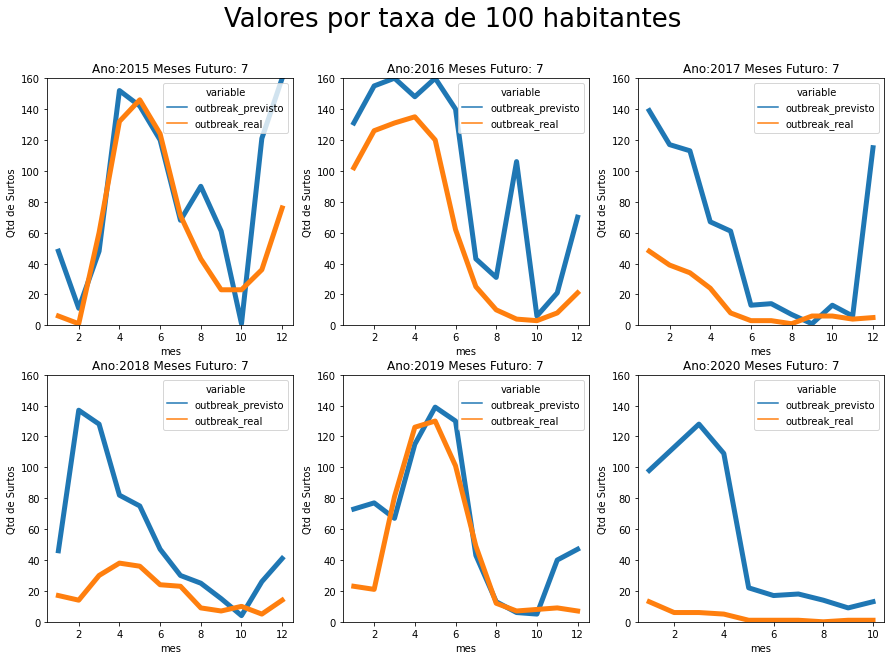

In [9]:
def analise_saida_classificacao_plot_line(df_result):

    for w in [0, 1, 2, 3, 4, 5, 6]:

        df_result_pivot = df_result[df_result["meses futuro"] == w]
        df_result_pivot = df_result_pivot.pivot_table(index=["ano", "mes"],
                                                values=["outbreak_real", "outbreak_previsto"],
                                                aggfunc="sum")

        df_result_pivot = df_result_pivot.reset_index()

        df_result_pivot = pd.melt(df_result_pivot, id_vars=['ano', 'mes'],
                          value_vars=['outbreak_previsto', 'outbreak_real'])

        f, ax = plt.subplots(figsize=(15, 10))
        sns.set_context(font_scale=0.9)
        for i, a in enumerate([2015, 2016, 2017, 2018, 2019, 2020]):
            ax = plt.subplot(231 + i)
            df_ano = df_result_pivot[df_result_pivot["ano"] == a]
            sns.lineplot(
                data=df_ano, x="mes", y="value", hue="variable", linewidth=5)
            plt.title("Ano:{} Meses Futuro: {}".format(a, w+1))
            plt.ylim(0, 160)
            plt.ylabel("Qtd de Surtos")
            ax.plot()

        if target == "taxa_dengue":
            f.suptitle("Valores por taxa de 100 habitantes", fontsize=26)
        else:
            f.suptitle("Valores Absolutos", fontsize=26)

        plt.show()

analise_saida_classificacao_plot_line(df_result)